In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# xLSTM

[paper](https://arxiv.org/abs/2405.04517)

xLSTM is a variant around the classical LSTM architecture that contains two different blocks: sLSTM and mLSTM.

## mLSTM

The mLSTM block has hidden state updated by terms of the form $k_{t}^{T} v_{t}$ as in Linear Attention models. Linear Attention removes the softmax from the classic attention formula:
$$O = (Q K^{T}) V$$
This has the effect that the computation can be re-expressed recurrently as
$$S_{t} = S_{t-1} + k_{t}^{T} v_{t}$$
$$y_{t} = q_{t} S_{t}$$

In mLSTM those equations are modified to incorporate a forget gate and an input gate:
$$C_{t} = f_{t} C_{t-1} + i_{t} (k_{t}^{T} v_{t})$$
the state is renamed $C$ by analogy with the cell state of an LSTM. In this equation, $f_{t}$ and i_{t}$ are computed from the concatenated q, k and v using a linear projection using sigmoid and exponential activations respectively, we'll talk about it more later.

The output is then computed using the state and $q_{t}$ along with a normalization term $n_{t}$:
$$y_{t} = (q_{t} @ C_{t}) / \max(q_{t} @ n_{t}, 1)$$
with this normalization factor being the weighted average of the $k_{t}$ using the same input and forget terms as for the cell state:
$$n_{t} = f_{t} n_{t-1} + i_{t} k_{t}.$$

The shapes are:
- $q_{t}$ -> `[batch_size, num_heads, head_size]`
- $k_{t}$ -> `[batch_size, num_heads, head_size]`
- $v_{t}$ -> `[batch_size, num_heads, head_size]`
- $C_{t}$ -> `[batch_size, num_heads, head_size, head_size]`
- $i_{t}$ -> `[batch_size, num_heads]`
- $f_{t}$ -> `[batch_size, num_heads]`
- $n_{t}$ -> `[batch_size, num_heads, head_size]`

The product between $q_{t}$ and $S_{t}$ or $n_{t}$ are matrix products as we accumulate over one of the `head_size` dimension in the state. All the other products are elementwise.

One tricky part is that $i_{t}$ using an exponential activation function:
$$i_{t} = \exp(\tilde{i_{t}}) \hbox{   and } f_{t} = \sigma(\tilde{f_{t}})$$
For numerical stability, since the output is a quotient involving exponentials in the numerator and denominator, we divide both by the exponential of a maximum (to make the inside of the exponentials negative numbers):
$$m_{t} = \max(\tilde{i_{t}}, m_{t-1} + \log(\sigma(\tilde{f_{t}}))))$$

This means that $i_{t}$ and $f_{t}$ are computed this way:
$$i_{t} = \exp(\tilde{i_{t}} - m_{t}) \hbox{   and } f_{t} = \exp(\log(\sigma(\tilde{f_{t}})) + m_{t-1} - m_{t})$$
then the update to the state is computed normally, there is just a change in the output because of the maximum in the denominator:
$$y_{t} = (q_{t} @C_{t}) / \max(q_{t} @ n_{t}, \exp(-m{t}))$$
Since the denominator can now be close to zero, we have to add an epsilon to it for numerical stability.

In terms of code, this looks like this:
```py
log_f = torch.nn.functional.logsigmoid(fgate)
max_new = torch.maximum(igate_preact, max_state + log_f)
i_gate = torch.exp(i_gate - new_max_state)

kv_outer_product = k[:, :, :, None] * v[:, :, None]
cell_new = f_gate[:, :, None, None] * cell_state + i_gate[:, :, None, None] * kv_outer_product
norm_new = f_gate[:, :, None] * norm_state + i_gate[:, :, None] * k

numerator = torch.einsum("bnh,bnhk->bnk", q, cell_new)
qn_dotproduct = torch.einsum("bnh,bnh->bn", q, norm_new)
denominator = torch.maximum(qn_dotproduct.abs(), torch.exp(-max_new)) + self.eps
out = numerator / denominator[:, :, None]
```

Then we can get the full code of the mLSTM cell:

In [9]:
def get_model_device(model):
    return next(iter(model.parameters())).device

In [11]:
class MLSTMCell(nn.Module):
    def __init__(self, hidden_size: int, num_heads: int = 8):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_size = hidden_size // num_heads
        self.eps = 1e-6

        self.igate_proj = nn.Linear(3 * hidden_size, num_heads, bias=True)
        self.fgate_proj = nn.Linear(3 * hidden_size, num_heads, bias=True)
        self.outnorm = nn.GroupNorm(num_groups=num_heads, num_channels=hidden_size)

    def forward(
        self, q: torch.Tensor, k: torch.Tensor, v: torch.Tensor, state
    ):
        batch_size, hidden_size = q.shape

        cell_state, norm_state, max_state = state

        qkv_cat = torch.cat([q, k, v], dim=-1)
        igate_preact = self.igate_proj(qkv_cat)
        fgate_preact = self.fgate_proj(qkv_cat)

        q = q.view(batch_size, self.num_heads, self.head_size)
        k = k.view(batch_size, self.num_heads, self.head_size)
        v = v.view(batch_size, self.num_heads, self.head_size)

        # Stabilization for gates
        log_f = torch.nn.functional.logsigmoid(fgate_preact)

        max_new = torch.maximum(igate_preact, max_state + log_f)

        i_gate = torch.exp(igate_preact - max_new)
        f_gate = torch.exp(log_f + max_state - max_new)

        # Scale keys
        k = k / math.sqrt(self.head_size)

        # Update memory and normalizer
        # C_new = f * C + i * k^T * v
        cell_new = (
            f_gate[:, :, None, None] * cell_state
            + i_gate[:, :, None, None] * k[:, :, :, None] * v[:, :, None]
        )
        # n_new = f * n + i * k
        norm_new = f_gate[:, :, None] * norm_state + i_gate[:, :, None] * k

        # Compute output: h = (q @ C) / max(q @ n, 1)
        numerator = torch.einsum("bnh,bnhk->bnk", q, cell_new)
        qn_dotproduct = torch.einsum("bnh,bnh->bn", q, norm_new)
        max_val = torch.exp(-max_new)
        denominator = torch.maximum(qn_dotproduct.abs(), max_val) + self.eps
        out = numerator / denominator[:, :, None]

        out = self.outnorm(out.view(batch_size, self.hidden_size))

        out = out.reshape(batch_size, self.hidden_size)

        assert cell_new.shape == cell_state.shape
        assert norm_new.shape == norm_state.shape
        assert max_new.shape == max_state.shape

        return out, (cell_new, norm_new, max_new)

    def init_state(self, batch_size: int, device: torch.device):
        return (
            torch.zeros(
                batch_size,
                self.num_heads,
                self.head_size,
                self.head_size,
                device=device,
            ),
            torch.zeros(batch_size, self.num_heads, self.head_size, device=device),
            torch.zeros(batch_size, self.num_heads, device=device),
        )

The mLSTM block also uses 1d conv on the sequence dimension. To be able to apply a convolutional layer on just one event, we need to keep around some of the last events in a state to be able to form a full window. More precisely, we need `kernel_size` events to be able to apply the convolutional layer and get one output, so we keep the `kernel_size-1` last events.

This is all coded in this layer:

In [6]:
class CausalConv1d(nn.Module):
    """
    Causal convolution layer: the hidden state contains the last kernel_size - 1 events
    (zeros initially) so we can have compute the convolution on a full window when
    receiving a new event.
    """

    def __init__(self, hidden_size, kernel_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.kernel_size = kernel_size
        self.conv = nn.Conv1d(
            hidden_size, hidden_size, kernel_size, groups=hidden_size, bias=True
        )

    def init_state(self, batch_size: int, device: torch.device | None = None):
        if device is None:
            device = get_model_device(self)
        return torch.zeros(
            batch_size, self.hidden_size, self.kernel_size - 1, device=device
        )

    def forward(self, x: torch.Tensor, state: torch.Tensor):
        x_with_state = torch.concat([state, x[:, :, None]], dim=-1)
        out = self.conv(x_with_state)
        new_state = x_with_state[:, :, 1:]
        return out.squeeze(-1), new_state

Here is an example of use on random inputs:

In [7]:
batch_size = 4
hidden_size = 32
kernel_size = 4
x = torch.randn(batch_size, hidden_size)

conv = CausalConv1d(hidden_size, kernel_size)
state = conv.init_state(batch_size)
out, new_state = conv(x, state)

Another thing that mLSTM uses is linear-by-block layers: think of it as a multi-head linear layer where each head has a separate set of weights. For the mLSTM block, the authors use many small blocks (size 4).

In [8]:
class BlockLinear(nn.Module):
    """
    Linear layers that has multiple blocks with different weights. This could
    also be implemented with a regular linear layer having diagonal-by-block weights.
    """

    def __init__(self, num_blocks: int, hidden_size: int, bias: bool = True):
        super().__init__()
        self.num_blocks = num_blocks
        self.block_size = hidden_size // num_blocks
        self.hidden_size = hidden_size
        self.weight = nn.Parameter(
            torch.empty(num_blocks, self.block_size, self.block_size)
        )
        if bias:
            self.bias = nn.Parameter(torch.empty(self.hidden_size))
        else:
            self.bias = None

    def forward(self, x):
        batch_size = x.shape[0]
        assert x.shape[1] == self.hidden_size
        x = x.view(batch_size, self.num_blocks, self.block_size)
        out = torch.einsum("bnh,nkh->bnk", x, self.weight)
        out = out.reshape(batch_size, self.hidden_size)
        if self.bias is not None:
            out += self.bias
        return out

The mLSTM block looks like this:
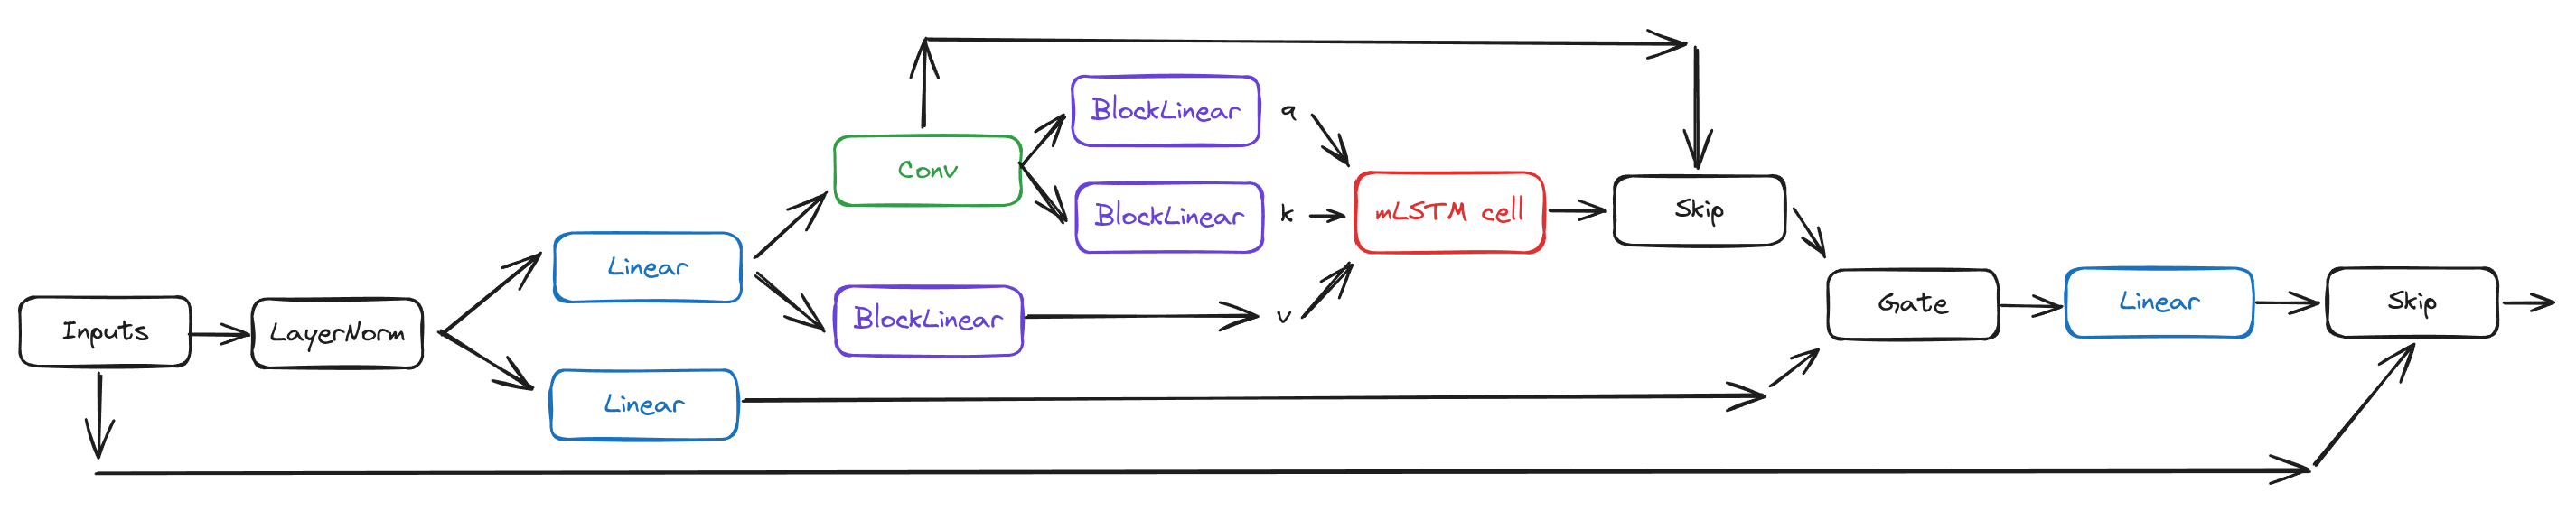

In [14]:
class MLSTMBlock(nn.Module):
    def __init__(
        self,
        hidden_size: int,
        num_heads: int = 8,
        conv_kernel_size: int = 4,
        qkv_proj_block_size: int = 4,
        expand_factor: int = 2,
    ):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads

        self.inner_size = expand_factor * hidden_size

        self.norm = nn.LayerNorm(hidden_size, bias=False)

        self.x_proj = nn.Linear(hidden_size, self.inner_size, bias=False)
        self.gate_proj = nn.Linear(hidden_size, self.inner_size, bias=False)

        num_blocks = self.inner_size // qkv_proj_block_size
        self.q_proj = BlockLinear(num_blocks, self.inner_size, bias=False)
        self.k_proj = BlockLinear(num_blocks, self.inner_size, bias=False)
        self.v_proj = BlockLinear(num_blocks, self.inner_size, bias=False)

        self.conv1d = CausalConv1d(self.inner_size, kernel_size=conv_kernel_size)

        self.mlstm_cell = MLSTMCell(self.inner_size, num_heads)
        self.proj_down = nn.Linear(self.inner_size, hidden_size, bias=False)
        self.learnable_skip = nn.Parameter(torch.ones(self.inner_size))

        self.head_size = self.inner_size // num_heads

    def forward(self, x: torch.Tensor, state):
        conv_state, recurrent_state = state

        skip = x

        x = self.norm(x)
        x_mlstm = self.x_proj(x)
        x_gate = self.gate_proj(x)

        x_conv, new_conv_state = self.conv1d(x_mlstm, conv_state)
        x_mlstm_conv = F.silu(x_conv)

        q = self.q_proj(x_mlstm_conv)
        k = self.k_proj(x_mlstm_conv)
        v = self.v_proj(x_mlstm)

        mlstm_out, new_recurrent_state = self.mlstm_cell(q, k, v, recurrent_state)

        mlstm_out_skip = mlstm_out + (self.learnable_skip * x_mlstm_conv)
        h_state = mlstm_out_skip * F.silu(x_gate)
        y = self.proj_down(h_state)

        return y + skip, (new_conv_state, new_recurrent_state)

    def init_state(self, batch_size: int, device: torch.device):
        return (
            self.conv1d.init_state(batch_size, device),
            self.mlstm_cell.init_state(batch_size, device),
        )

## sLSTM

The second buildind block of xLSTM is the sLSTM block. sLSTM is a variant using the following equations:
$$c_{t} = f_{t} * c_{t-1} + i_{t} * z_{t}$$
$$y_{t} = o_{t} * c_{t} / n_{t}$$
where $c_{t}$ denote the cell state, $f_{t}$, $i_{t}$, $z_{t}$ and $o_{t}$ are computed from the inputs using linear layers (they are the traditional forget gate, input gate, cell input gate and output gate from the LSTM) and $n_{t}$ is a normalization factor similar to the one in mLSTM:
$$n_{t} = f_{t} n_{t-1} + i_{t}$$



Like in mLSTM, $i_{t}$ uses an exponential activation function, $f_{t}$ a sigmoid, and the result is a quotient of factors using both those terms. The authors use the same trick for numerical stability, dividing both terms by the exponential of a maximum:
$$m_{t} = \max(\tilde{i_{t}}, m_{t-1} + \log(\sigma(\tilde{f_{t}}))))$$
and then
$$i_{t} = \exp(\tilde{i_{t}} - m_{t}) \hbox{   and } f_{t} = \exp(\log(\sigma(\tilde{f_{t}})) + m_{t-1} - m_{t})$$

The shapes are easier to reason about here: everything is `[batch_size, hidden_size]`, and all multiplications are pointwise.

In terms of code, this looks like this:
```py
log_f_plus_m = max_state + torch.nn.functional.logsigmoid(f)
max_new = torch.maximum(i, log_f_plus_m)

i_gate = torch.exp(i - max_new)
f_gate = torch.exp(log_f_plus_m - max_new)
o_gate = torch.sigmoid(o)
z_gate = torch.tanh(z)

cell_new = f_gate * cell_state + i_gate * z_gate
norm_new = f_gate * norm_state + i_gate
y_new = o_gate * cell_new / (norm_new + eps)
```

The sLSTM cell looks like this:

In [18]:
class SLSTMCell(nn.Module):
    def __init__(self, hidden_size: int, num_heads: int = 4):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_size = hidden_size // num_heads
        self.eps = 1e-6

    def forward(
        self,
        i: torch.Tensor,
        f: torch.Tensor,
        z: torch.Tensor,
        o: torch.Tensor,
        state,
    ):
        cell_state, norm_state, max_state = state

        log_f_plus_m = max_state + torch.nn.functional.logsigmoid(f)

        # Use torch.where to avoid data-dependent branching
        max_new = torch.maximum(i, log_f_plus_m)

        # Compute stabilized exponential gates
        o_gate = torch.sigmoid(o)
        i_gate = torch.exp(i - max_new)
        f_gate = torch.exp(log_f_plus_m - max_new)

        cell_new = f_gate * cell_state + i_gate * torch.tanh(z)
        norm_new = f_gate * norm_state + i_gate
        y_new = o_gate * cell_new / (norm_new + self.eps)

        return y_new, (cell_new, norm_new, max_new)

    def init_state(self, batch_size: int, device: torch.device):
        return (
            torch.zeros(batch_size, self.hidden_size, device=device),
            torch.zeros(batch_size, self.hidden_size, device=device),
            torch.zeros(batch_size, self.hidden_size, device=device) - float("inf"),
        )

The SLSTM block looks like this:

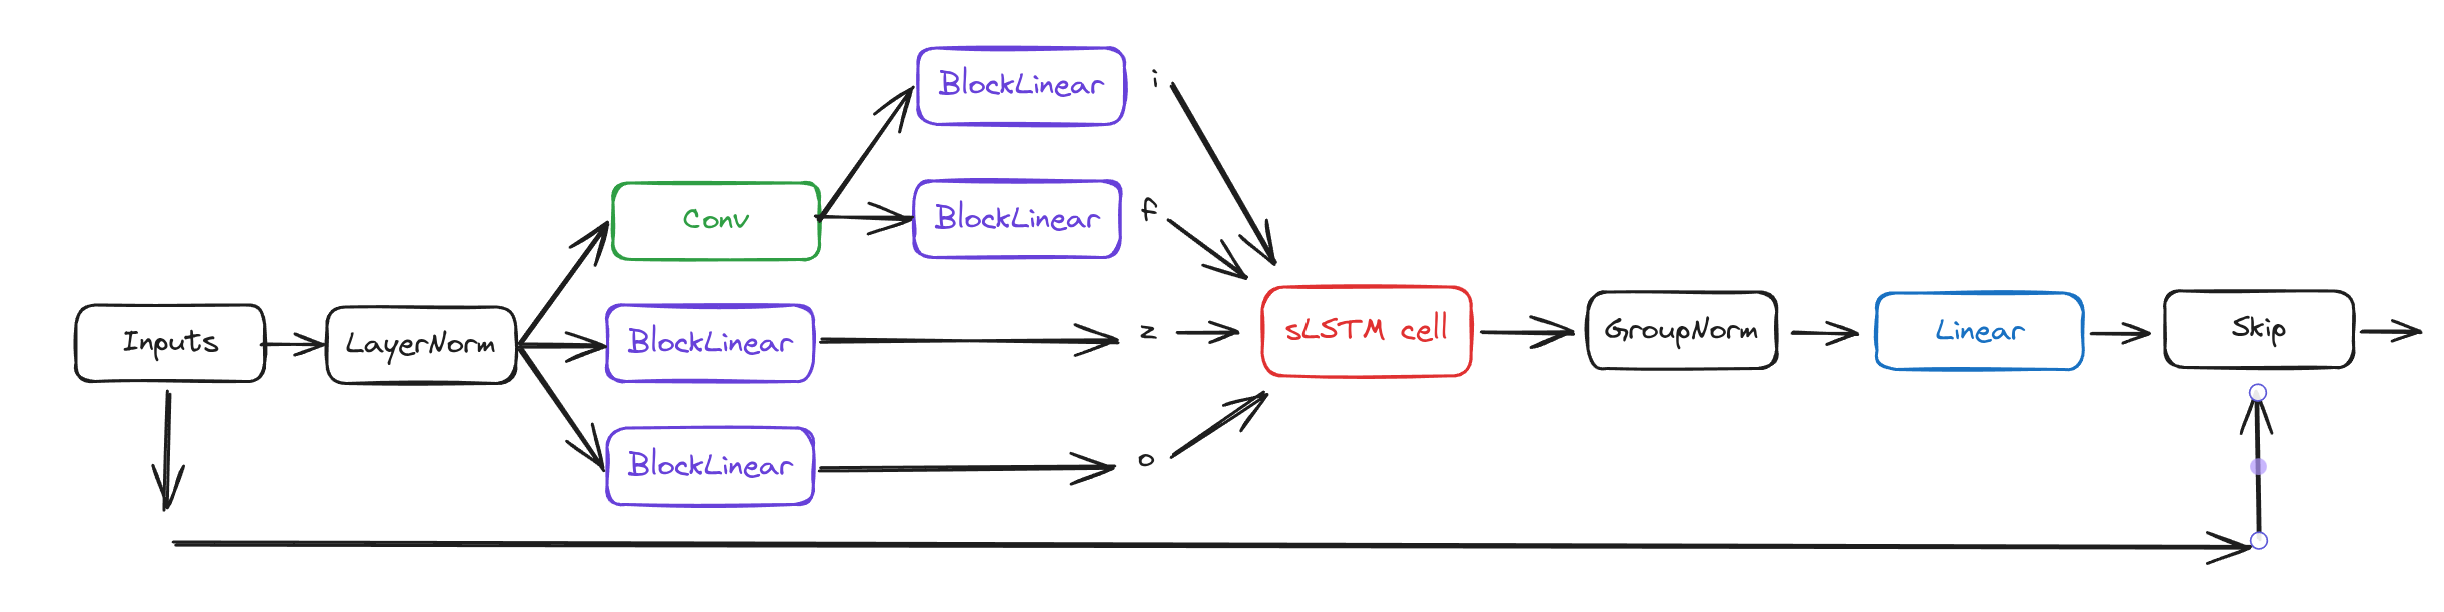

The only thing missing in this diagram is the way the recurrent state is also going through some `BlockLinear` layers for each gate, this can be seen better in the code below:

In [19]:
class SLSTMBlock(nn.Module):
    def __init__(self, hidden_size: int, num_heads: int = 4, conv_kernel_size: int = 4):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads

        self.norm = nn.LayerNorm(hidden_size, bias=False)
        self.conv1d = CausalConv1d(hidden_size, kernel_size=conv_kernel_size)
        self.igate_input = BlockLinear(num_heads, hidden_size, bias=False)
        self.fgate_input = BlockLinear(num_heads, hidden_size, bias=False)
        self.zgate_input = BlockLinear(num_heads, hidden_size, bias=False)
        self.ogate_input = BlockLinear(num_heads, hidden_size, bias=False)

        self.igate_state = BlockLinear(num_heads, hidden_size)
        self.fgate_state = BlockLinear(num_heads, hidden_size)
        self.zgate_state = BlockLinear(num_heads, hidden_size)
        self.ogate_state = BlockLinear(num_heads, hidden_size)

        self.slstm_cell = SLSTMCell(hidden_size, num_heads)
        self.group_norm = nn.GroupNorm(num_groups=num_heads, num_channels=hidden_size)

    def forward(self, x: torch.Tensor, state):
        conv_state, recurrent_state, slstm_state = state

        skip = x
        x = self.norm(x)

        x_conv, new_conv_state = self.conv1d(x, conv_state)
        x_conv_act = F.silu(x_conv)

        i = self.igate_input(x_conv_act) + self.igate_state(recurrent_state)
        f = self.fgate_input(x_conv_act) + self.fgate_state(recurrent_state)
        z = self.zgate_input(x) + self.zgate_state(recurrent_state)
        o = self.ogate_input(x) + self.ogate_state(recurrent_state)

        new_recurrent_state, new_slstm_state = self.slstm_cell(i, f, z, o, slstm_state)
        slstm_out = self.group_norm(new_recurrent_state)

        return slstm_out + skip, (new_conv_state, new_recurrent_state, new_slstm_state)

    def init_state(self, batch_size: int, device: torch.device):
        return (
            self.conv1d.init_state(batch_size, device),
            torch.zeros(batch_size, self.hidden_size, device=device),
            self.slstm_cell.init_state(batch_size, device),
        )